# Making question

## Import Các thư viện cần thiết

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None) 
import re
from moviepy import ImageSequenceClip
import os
from IPython.display import Video



Đọc dữ liệu từ các file csv đã được làm sạch

In [52]:
match_overview_df = pd.read_csv('./data/clean_data/match_overview.csv', delimiter='\t')
match_statistics_df = pd.read_csv('./data/clean_data/match_statistics.csv', delimiter='\t')
team_ranking_df = pd.read_csv('./data/clean_data/team_rankings.csv', delimiter=',')
team_profile_df = pd.read_csv('./data/clean_data/team_profile.csv', delimiter=',')

In [53]:
match_overview_df.rename(columns={'Match ID': 'match_id'}, inplace=True)
match_overview_df.head(5)

,match_id,Date,Season,Home Team,Away Team,Home Lineup,Away Lineup,Fulltime Score,Winner
0,3050173,2018-08-11,18/19,Newcastle United,Tottenham Hotspur,4-4-1-1,4-3-2-1,1:2,Tottenham Hotspur
1,3050169,2018-08-11,18/19,Fulham FC,Crystal Palace,4-3-3 Attacking,4-4-2,0:2,Crystal Palace
2,3050168,2018-08-11,18/19,AFC Bournemouth,Cardiff City,4-4-2 double 6,4-1-4-1,2:0,AFC Bournemouth
3,3050176,2018-08-11,18/19,Wolverhampton Wanderers,Everton FC,3-4-3,4-2-3-1,2:2,Draw
4,3050172,2018-08-10,18/19,Manchester United,Leicester City,4-1-4-1,4-4-2 double 6,2:1,Manchester United


In [54]:
match_statistics_df.head(10)

,match_id,home_total_shots,home_shots_saved,home_corners,home_free_kicks,home_offsides,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards
0,3050176,4,3,3,10,7,2,5,2,6,9,7,3,0,3
1,3050173,2,4,3,12,11,1,6,1,5,12,12,0,2,2
2,3050175,5,1,8,19,13,0,1,2,2,13,16,3,2,2
3,3050171,8,2,5,12,14,5,2,4,4,19,9,3,1,2
4,3050170,2,1,2,9,8,2,4,2,5,10,8,1,2,1
5,3050172,6,3,2,9,11,4,4,4,5,15,7,2,2,1
6,3050174,3,6,8,15,12,2,6,3,5,14,11,4,0,1
7,3050167,3,7,2,15,11,7,9,3,9,18,13,2,2,2
8,3050168,3,1,7,10,12,0,1,0,4,12,8,2,1,1
9,3050169,6,7,5,14,8,2,9,6,5,10,11,3,1,2


In [55]:
team_ranking_df.head(10)

,Season,Team,Ranking,Wins,Draws,Losses,Goals Scored,Goals Conceded
0,14/15,Chelsea FC,1,26,9,3,73,32
1,14/15,Manchester City,2,24,7,7,83,38
2,14/15,Arsenal FC,3,22,9,7,71,36
3,14/15,Manchester United,4,20,10,8,62,37
4,14/15,Tottenham Hotspur,5,19,7,12,58,53
5,14/15,Liverpool FC,6,18,8,12,52,48
6,14/15,Southampton FC,7,18,6,14,54,33
7,14/15,Swansea City,8,16,8,14,46,49
8,14/15,Stoke City,9,15,9,14,48,45
9,14/15,Crystal Palace,10,13,9,16,47,51


In [56]:
team_profile_df.head(10)

,Season,Club,Squad,Average age,Foreigners,Total market value
0,14/15,Chelsea FC,38,25.4,28,0.358592
1,14/15,Manchester United,43,25.4,26,0.321752
2,14/15,Manchester City,34,27.1,27,0.281147
3,14/15,Arsenal FC,42,24.5,29,0.257345
4,14/15,Liverpool FC,35,24.8,21,0.193470
5,14/15,Tottenham Hotspur,42,25.2,25,0.178763
6,14/15,Southampton FC,37,25.1,20,0.112047
7,14/15,Everton FC,40,25.7,22,0.092579
8,14/15,Newcastle United,42,24.4,28,0.062134
9,14/15,West Ham United,36,26.2,21,0.059221


## Câu hỏi 1: Các tình huống bóng chết (phạt góc, đá phạt) có vai trò quan trọng hơn trong các trận đấu giữa các đội có thứ hạng gần nhau (derbies, cuộc đối đầu nhóm đầu bảng) không?

**Ý nghĩa của câu hỏi:**  
Trả lời câu hỏi này sẽ giúp chúng ta biết được các đội mạnh khi đối đầu với nhau thì sẽ có những chiến thuật gì

**Các DataFrame được sử dụng để phân tích:**   
- `match_overview_df`: Chứa dữ liệu về thông số của mỗi trận đấu
- `match_statistic_df`: Chứa dữ liệu về thông số của mỗi trận đấu
- `team_ranking_df`: Chứa dữ liệu về xếp hạng của các đội bóng

Đầu tiên, ta cần kết hợp 2 DataFrame ở trên lại để phù hợp hơn cho việc phân tích dữ liệu cho câu hỏi trên


Để làm được điều đó, ta dựa theo cột `match_id` để lấy thông tin về các trận đấu

In [57]:
merged_df = pd.merge(match_overview_df, match_statistics_df, on='match_id')

In [58]:
merged_df.sample(5)

,match_id,Date,Season,Home Team,Away Team,Home Lineup,Away Lineup,Fulltime Score,Winner,home_total_shots,home_shots_saved,home_corners,home_free_kicks,home_offsides,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards
1908,2578006,2015-10-24,15/16,West Ham United,Chelsea FC,4-2-3-1,4-2-3-1,2:1,West Ham United,6,3,7,14,13,2,4,4,4,15,11,3,1,6
1946,2578037,2015-11-21,15/16,Manchester City,Liverpool FC,4-2-3-1,4-2-3-1,1:4,Liverpool FC,3,6,11,16,5,1,9,2,5,6,11,5,0,3
63,3050236,2018-09-29,18/19,Wolverhampton Wanderers,Southampton FC,5-4-1,4-4-2 double 6,2:0,Wolverhampton Wanderers,6,6,8,8,12,0,6,4,6,12,6,2,3,1
459,2486535,2014-10-04,14/15,Aston Villa,Manchester City,4-3-2-1,4-2-3-1,0:2,Manchester City,2,5,0,9,4,1,8,2,7,5,6,3,0,1
839,2872241,2017-11-26,17/18,Southampton FC,Everton FC,4-4-1-1,4-4-2 double 6,4:1,Southampton FC,5,1,7,12,6,0,2,1,2,6,12,0,0,0


Định nghĩa các trận đấu quan trọng là những trận đấu của các đội trong top 6 của giải đấu. Chúng ta sẽ không làm mục derbies vì mục đó không có trong dataFrame

Đầu tiên thì chúng ta cần thêm một cột là `is_top_team_match` để biết được xem trận đấu ấy có phải là trận đấu giữa các đội top cao không ?

In [59]:
merged_with_rankings = merged_df.merge(team_ranking_df, how='left', left_on=['Season', 'Home Team'], right_on=['Season', 'Team'])
merged_with_rankings = merged_with_rankings.merge(team_ranking_df, how='left', left_on=['Season', 'Away Team'], right_on=['Season', 'Team'], suffixes=('_home', '_away'))

merged_with_rankings['is_top_team_match'] = (merged_with_rankings['Ranking_home'] <= 6) & (merged_with_rankings['Ranking_away'] <= 6)

merged_df['is_top_team_match'] = merged_with_rankings['is_top_team_match']

In [60]:
high_stakes_matches = merged_df[(merged_df['is_top_team_match'] == 1)]
high_stakes_matches.sample(5)

,match_id,Date,Season,Home Team,Away Team,Home Lineup,Away Lineup,Fulltime Score,Winner,home_total_shots,home_shots_saved,home_corners,home_free_kicks,home_offsides,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards,is_top_team_match
1681,3592123,2022-01-23,21/22,Chelsea FC,Tottenham Hotspur,4-1-4-1,4-4-2 double 6,2:0,Chelsea FC,15,3,10,14,17,0,6,5,3,17,14,1,2,1,True
2282,2698142,2016-10-23,16/17,Chelsea FC,Manchester United,3-4-2-1,4-5-1 flat,4:0,Chelsea FC,7,5,5,20,7,2,5,3,7,9,17,3,3,2,True
3228,4095201,2023-11-25,23/24,Manchester City,Liverpool FC,3-4-2-1,4-3-3 Attacking,1:1,Draw,16,2,9,11,9,3,8,4,6,8,11,4,1,3,True
2492,2698348,2017-04-05,16/17,Chelsea FC,Manchester City,3-4-2-1,4-2-3-1,2:1,Chelsea FC,3,6,2,13,10,1,7,1,9,11,13,0,1,3,True
38,3050214,2018-09-15,18/19,Tottenham Hotspur,Liverpool FC,4-3-1-2,4-3-3 Attacking,1:2,Liverpool FC,3,8,5,16,18,3,10,2,4,21,14,2,0,0,True


Chúng ta sẽ loại bỏ bớt cột `match_id` để thông tin trở nên dễ đọc hơn và dễ phân tích hơn

In [61]:
high_stakes_matches.drop(['match_id'], axis=1, inplace=True)

In [62]:
high_stakes_matches

,Date,Season,Home Team,Away Team,Home Lineup,Away Lineup,Fulltime Score,Winner,home_total_shots,home_shots_saved,home_corners,home_free_kicks,home_offsides,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards,is_top_team_match
7,2018-08-12,18/19,Arsenal FC,Manchester City,4-2-3-1,4-2-3-1,0:2,Manchester City,3,7,2,15,11,7,9,3,9,18,13,2,2,2,True
19,2018-08-18,18/19,Chelsea FC,Arsenal FC,4-3-3 Attacking,4-2-3-1,3:2,Chelsea FC,11,5,5,11,12,3,7,8,1,15,8,3,0,2,True
38,2018-09-15,18/19,Tottenham Hotspur,Liverpool FC,4-3-1-2,4-3-3 Attacking,1:2,Liverpool FC,3,8,5,16,18,3,10,2,4,21,14,2,0,0,True
44,2018-08-27,18/19,Manchester United,Tottenham Hotspur,3-5-2 flat,4-3-1-2,0:3,Tottenham Hotspur,5,3,5,18,11,2,6,5,2,13,17,1,2,3,True
72,2018-10-20,18/19,Chelsea FC,Manchester United,4-3-3 Attacking,4-3-3 Attacking,2:2,Draw,6,2,5,18,9,2,4,4,3,11,17,1,2,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3433,2024-05-14,23/24,Tottenham Hotspur,Manchester City,4-3-1-2,4-2-3-1,0:2,Manchester City,10,3,7,11,14,2,8,6,4,14,11,2,3,3,True
3442,2024-04-27,23/24,Aston Villa,Chelsea FC,4-4-1-1,4-2-3-1,2:2,Draw,9,3,2,14,13,2,21,3,4,13,14,4,3,4,True
3444,2024-04-28,23/24,Tottenham Hotspur,Arsenal FC,4-2-3-1,4-3-3 Attacking,2:3,Arsenal FC,14,1,8,14,12,3,9,0,6,12,16,4,2,1,True
3456,2024-05-05,23/24,Liverpool FC,Tottenham Hotspur,4-3-3 Attacking,4-3-3 Attacking,4:2,Liverpool FC,25,4,8,12,14,7,11,8,3,12,12,2,1,4,True


Tiếp theo, chúng ta sẽ so sánh các chỉ số tình huống bóng chết `home_corners`,`away_corners`,`home_free_kicks` và `away_free_kicks` giữa `Home Team` và `Away Team` bằng cách tính trung bình của các chỉ số này và phân nhóm theo `Winner` của trận đấu

In [63]:
set_pieces_analysis = high_stakes_matches.groupby('Winner')[['home_corners', 'away_corners', 'home_free_kicks', 'away_free_kicks']].mean()

In [64]:
set_pieces_analysis

,home_corners,away_corners,home_free_kicks,away_free_kicks
Winner,,,,
Arsenal FC,6.391304,4.260870,12.173913,11.782609
Aston Villa,5.500000,3.000000,10.250000,12.750000
Brighton & Hove Albion,6.500000,2.750000,13.750000,9.250000
Chelsea FC,4.960000,5.920000,12.960000,12.600000
Draw,5.679487,4.717949,13.089744,12.384615
Leicester City,7.500000,6.333333,11.833333,10.666667
Liverpool FC,6.242424,3.454545,11.696970,10.454545
Manchester City,4.888889,3.622222,11.155556,12.066667
Manchester United,5.225806,4.483871,11.903226,12.741935


Để dễ dàng trực quan hóa dữ liệu hơn, chúng ta sẽ vẽ biểu đồ cột để so sánh các chỉ số trên giữa các trận đấu

<Figure size 1000x600 with 0 Axes>

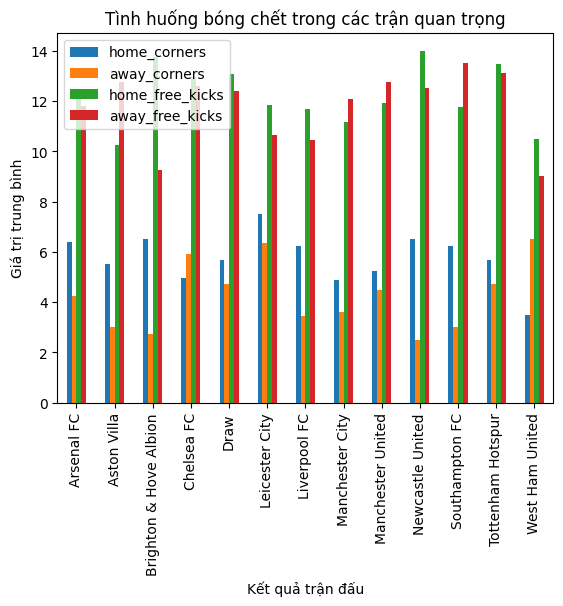

In [65]:
plt.figure(figsize=(10, 6))
set_pieces_analysis.plot(kind='bar', title='Tình huống bóng chết trong các trận quan trọng')
plt.xlabel('Kết quả trận đấu')
plt.ylabel('Giá trị trung bình')
plt.show()

**Nhận xét:**  

**1. Sự khác biệt giữa phạt góc và đá phạt**
- Trung bình số lượng phạt góc (`home_corners` và `away_corners`) thấp hơn đáng kể so với số lần đá phạt (`home_free_kicks` và `away_free_kicks`) ở hầu hết các đội. Qua đó cho thấy các tình huống phạt góc ít xảy ra hơn trong các trận đấu quan trọng, nhưng khi xảy ra, chúng có thể mang lại cơ hội lớn.

**2. Sự vượt trội của đội chủ nhà**
- Trong nhiều trận đấu, số lượng phạt góc và đá phạt của đội chủ nhà (`home_corners` và `home_free_kicks`) cao hơn đội khách. Điều này cho thấy lợi thế sân nhà có thể ảnh hưởng đến khả năng tấn công và tạo ra các tình huống bóng chết.

**3. Sự cân bằng trong các trận hòa**
- Trong các trận hòa (`Draw`), số lượng phạt góc và đá phạt của cả hai đội khá đồng đều nhau và không có sự chênh lệch lớn. Thông qua đó chúng ta có thể chắc rằng các trận hòa thường là kết quả của sự cân bằng trong lối chơi giữa hai đội.

**4. Đội bóng vượt trội trong việc tạo cơ hội**
- Một số đội, như Manchester City và Liverpool, có chỉ số phạt góc và đá phạt vượt trội, đặc biệt khi giành chiến thắng.
- Điều này chứng minh rằng các đội bóng mạnh trong những năm gần đây thường tạo ra nhiều cơ hội nguy hiểm từ các tình huống cố định.

**5. Hiệu quả trong các tình huống bóng chết**
- Các đội như Arsenal và Chelsea có sự chênh lệch rõ rệt giữa chỉ số của đội nhà và đội khách khi thắng, chứng tỏ rằng họ biết cách tận dụng tốt lợi thế từ các tình huống bóng chết khi chơi trên sân nhà.

**Tổng kết:**
- Các tình huống bóng chết như phạt góc và đá phạt đóng vai trò quan trọng trong các trận đấu quan trọng giữa các đội top đầu.
- Lợi thế sân nhà không chỉ giúp tạo ra nhiều cơ hội mà còn có thể gây áp lực lên đối thủ, dẫn đến nhiều lỗi và tình huống đá phạt.


## Câu hỏi 2: Có đội nào chiến thắng dù có ít cú sút, phạt góc, hoặc các chỉ số kiểm soát bóng hơn không? Những yếu tố nào định hình các chiến thắng "hiệu quả" này?

**Ý nghĩa khi trả lời câu hỏi này:**
- Trả lời câu hỏi này sẽ giúp chúng ta hiểu rõ hơn về cách mà các đội bóng có thể chiến thắng mà không cần phải tạo ra nhiều cơ hội.
Các cột liên quan:
- `home_total_shots`, `away_total_shots`: số lượng cú sút của đội chủ nhà và đội khách
- `home_corners`, `away_corners`: số lượng phạt góc của đội chủ nhà và đội khách

Vì đã có sẵn `merge_df` như đã nói ở câu hỏi 1, nên chúng ta sẽ đi thẳng vào việc phân tích câu hỏi này. Đầu tiên thì chúng ta sẽ định nghĩa các trận đấu hiệu quả `effective_wins`

In [66]:
def determine_effective_wins(row):
    if row['Winner'] == row['Home Team']:
        return (
            row['home_total_shots'] < row['away_total_shots'] and
            row['home_corners'] < row['away_corners'] and
            (row['home_corners'] + row['home_free_kicks']) < (row['away_corners'] + row['away_free_kicks'])
        )
    elif row['Winner'] == row['Away Team']:
        return (
            row['away_total_shots'] < row['home_total_shots'] and
            row['away_corners'] < row['home_corners'] and
            (row['away_corners'] + row['away_free_kicks']) < (row['home_corners'] + row['home_free_kicks'])
        )
    return False

Tiếp theo thì chúng ta sẽ add thêm 1 cột là `effective_wins` để biết được xem trận đấu ấy có phải là trận đấu hiệu quả không

In [67]:
merged_df['Effective Win'] = merged_df.apply(determine_effective_wins, axis=1)

Chúng ta sẽ loại bỏ bớt cột `match_id` để thông tin trở nên dễ đọc hơn và dễ phân tích hơn và lọc các trận thắng 'hiệu quả'

In [73]:
effective_wins = merged_df[merged_df['Effective Win'] == True]
effective_wins

,Date,Season,Home Team,Away Team,Home Lineup,Away Lineup,Fulltime Score,Winner,home_total_shots,home_shots_saved,home_corners,home_free_kicks,home_offsides,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards,is_top_team_match,Effective Win,Home Formation,Away Formation
30,2018-09-01,18/19,Crystal Palace,Southampton FC,4-4-2 double 6,4-4-2 double 6,0:2,Southampton FC,6,3,7,13,10,0,5,6,4,10,12,1,1,1,False,True,4-4-2,4-4-2
42,2018-09-15,18/19,Newcastle United,Arsenal FC,4-4-2 double 6,4-2-3-1,1:2,Arsenal FC,3,0,10,13,12,3,2,2,4,15,12,1,0,0,False,True,4-4-2,4-2-3-1
48,2018-09-22,18/19,Burnley FC,AFC Bournemouth,4-4-2 double 6,4-4-2 double 6,4:0,Burnley FC,5,6,3,8,17,1,6,1,8,18,6,2,2,0,False,True,4-4-2,4-4-2
61,2018-09-23,18/19,Arsenal FC,Everton FC,4-2-3-1,4-2-3-1,2:0,Arsenal FC,5,6,5,15,17,1,6,3,9,18,13,2,2,1,False,True,4-2-3-1,4-2-3-1
64,2018-09-29,18/19,West Ham United,Manchester United,4-1-4-1,3-5-2 flat,3:1,West Ham United,3,3,4,15,12,2,4,1,9,14,11,4,0,1,False,True,4-1-4-1,3-5-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421,2024-04-14,23/24,Liverpool FC,Crystal Palace,4-3-3 Attacking,3-4-3,0:1,Crystal Palace,21,3,11,9,10,2,8,5,1,10,10,5,1,1,False,True,4-3-3,3-4-3
3428,2024-04-20,23/24,Sheffield United,Burnley FC,4-2-3-1,4-4-2,1:4,Burnley FC,18,5,11,9,10,2,16,10,2,10,9,1,1,0,False,True,4-2-3-1,4-4-2
3444,2024-04-28,23/24,Tottenham Hotspur,Arsenal FC,4-2-3-1,4-3-3 Attacking,2:3,Arsenal FC,14,1,8,14,12,3,9,0,6,12,16,4,2,1,True,True,4-2-3-1,4-3-3
3465,2024-05-11,23/24,Wolverhampton Wanderers,Crystal Palace,3-5-2 flat,3-4-3,1:3,Crystal Palace,14,0,8,11,13,3,13,7,3,13,12,5,3,3,False,True,3-5-2,3-4-3


Sau đó, ta sẽ trực quan hóa dữ liệu bằng cách đếm số trận thắng 'hiệu quả' theo đội

In [74]:
team_effective_wins = effective_wins['Winner'].value_counts()

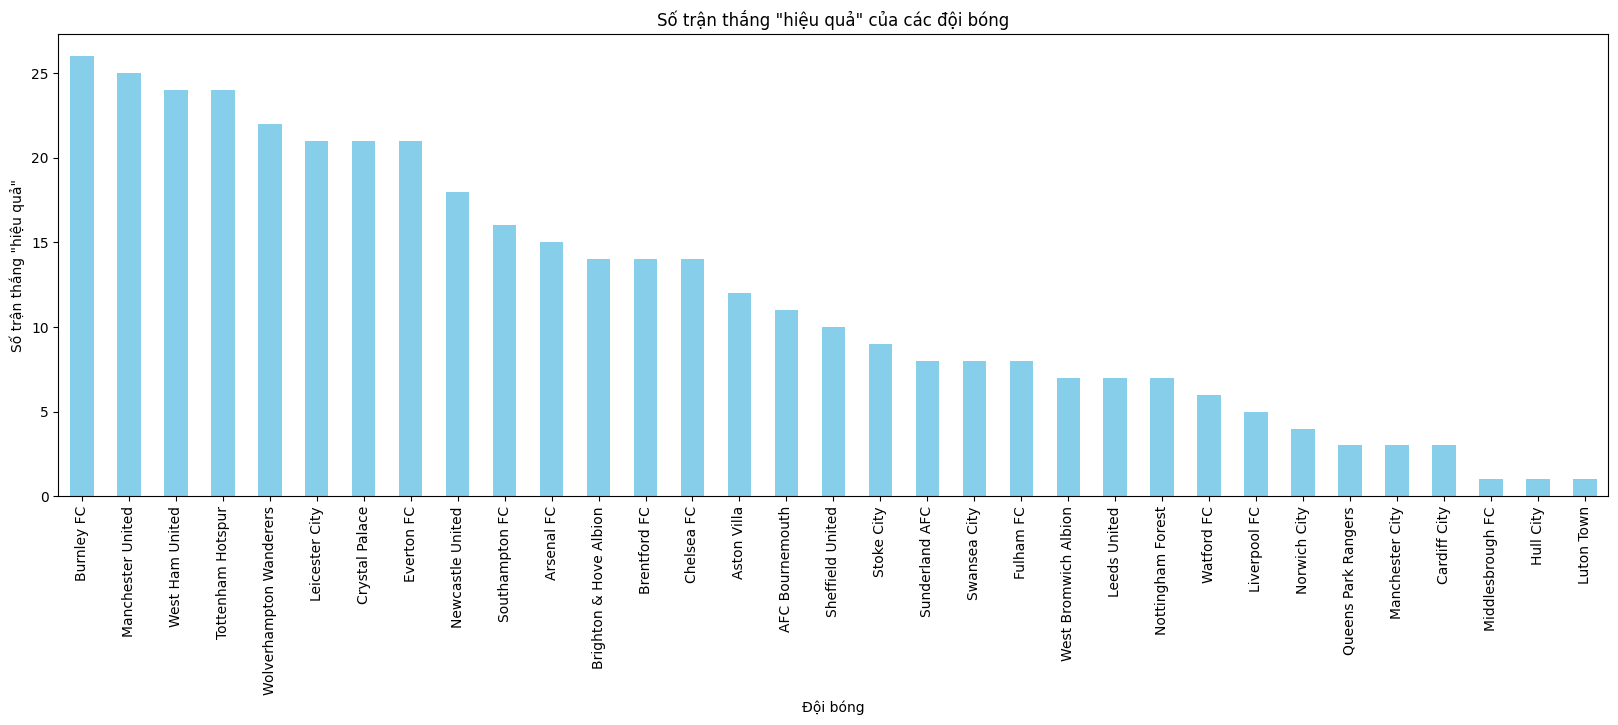

In [77]:
plt.figure(figsize=(20, 6))
team_effective_wins.plot(kind='bar', color='skyblue', title='Số trận thắng "hiệu quả" của các đội bóng')
plt.xlabel('Đội bóng')
plt.ylabel('Số trận thắng "hiệu quả"')
plt.xticks(rotation=90)
plt.show()

Sau khi đã có kết quả bên trên, ta trực quan hóa dữ liệu thu được

In [80]:
print("Chi tiết các trận thắng \"hiệu quả\":")
print(effective_wins[['Home Team', 'Away Team', 'Winner']])


Chi tiết các trận thắng "hiệu quả":
                    Home Team          Away Team             Winner
30             Crystal Palace     Southampton FC     Southampton FC
42           Newcastle United         Arsenal FC         Arsenal FC
48                 Burnley FC    AFC Bournemouth         Burnley FC
61                 Arsenal FC         Everton FC         Arsenal FC
64            West Ham United  Manchester United    West Ham United
...                       ...                ...                ...
3421             Liverpool FC     Crystal Palace     Crystal Palace
3428         Sheffield United         Burnley FC         Burnley FC
3444        Tottenham Hotspur         Arsenal FC         Arsenal FC
3465  Wolverhampton Wanderers     Crystal Palace     Crystal Palace
3469   Brighton & Hove Albion  Manchester United  Manchester United

[389 rows x 3 columns]


**Nhận xét: Cách các đội dù tạo ra ít cơ hội và tình huống hơn vẫn dành về 3 điểm ở giải đấu EPL**  
- Từ biểu đồ, có thể thấy một số đội bóng xuất sắc trong việc đạt được "chiến thắng hiệu quả," tức là chiến thắng dù có ít cú sút, phạt góc, hoặc thời gian kiểm soát bóng hơn. Các đội nổi bật bao gồm:

1. `Burnley FC`: Đứng đầu danh sách với số trận thắng hiệu quả cao nhất, `Burnley` tỏ ra rất giỏi trong việc biến bất lợi thành chiến thắng.
2. `Manchester United` và `West Ham United`: Hai đội này cũng có nhiều chiến thắng hiệu quả, cho thấy khả năng thi đấu tốt dưới áp lực.
3. `Tottenham Hotspur` và `Wolverhampton Wanderers`: Xếp sau nhưng vẫn có số trận thắng hiệu quả đáng kể, thể hiện sự hiệu quả và khả năng thích nghi trong các trận đấu.

Ngược lại, các đội như `Hull City`, `Luton Town`, và `Middlesbrough FC` có rất ít chiến thắng hiệu quả, có thể do họ gặp khó khăn trong việc xoay chuyển tình thế khi gặp các đội bóng mạnh hơn cũng như là thiếu hiệu quả trong việc tận dụng cơ hội.

---

**Những Yếu Tố Định Hình Chiến Thắng Hiệu Quả**  
- Khả năng giành chiến thắng trong các điều kiện khác nhau có thể được nhìn nhận qua các yếu tố sau:  

1. **Sự Ổn Định Ở Top Đầu**:  
   - Các đội như `Burnley FC`, `Manchester United`, và `West Ham United` dẫn đầu với số trận thắng hiệu quả cao nhất.  
   - Điều này cho thấy sự ổn định và khả năng giành điểm tối đa trong nhiều tình huống.  

2. **Sự Cạnh Tranh Ở Mức Trung Bình**:  
   - `Wolverhampton Wanderers`, `Leicester City` và `Crystal Palace` duy trì số trận thắng khá đồng đều, phản ánh khả năng phòng ngự và giữ lợi thế tốt.  
   - Nhóm này thường là những đội bóng có lối chơi kỷ luật và chắc chắn.  

3. **Khoảng Cách Ở Nhóm Dưới**:  
   - `Leeds United`, `Nottingham Forest` và `Watford FC` có số trận thắng hiệu quả thấp hơn nhiều, cho thấy sự thiếu ổn định hoặc khả năng kết liễu trận đấu chưa tốt.  

4. **Các Đội Bị Tụt Lại**:  
   - `Luton Town`, `Hull City` và `Middlesbrough FC` là ba đội có số trận thắng hiệu quả thấp nhất, phản ánh sự thiếu hiệu quả trong cả phòng ngự và tấn công.  

5. **Sự Vượt Trội Của Burnley FC**:  
   - `Burnley FC` dẫn đầu với số trận thắng hiệu quả cao nhất, cho thấy lối chơi thực dụng và khả năng tận dụng cơ hội nhỏ để giành trọn 3 điểm.  

---

### Kết Luận
Có nhiều đội bóng chứng minh được khả năng chiến thắng dù có ít cú sút, phạt góc, hoặc thời gian kiểm soát bóng hơn. Những yếu tố như tổ chức phòng ngự, khả năng dứt điểm, kỷ luật chiến thuật, và tinh thần kiên cường đóng vai trò quan trọng trong việc định hình các chiến thắng "hiệu quả" này.

Dữ liệu này cho thấy, mặc dù các chỉ số truyền thống như kiểm soát bóng và cơ hội ghi bàn rất quan trọng, nhưng chúng không đảm bảo thành công. Hiệu quả và khả năng thích nghi vẫn là yếu tố quyết định.
